# Speed Up Loading The Data By Importing from the Parquet Dataset

Dataset Link here: https://www.kaggle.com/robikscube/ubiquant-parquet

Read about parquet files here: https://databricks.com/glossary/what-is-parquet

Excerpt from the above website:

**What is Parquet?**

*Parquet is an open source file format available to any project in the Hadoop ecosystem. Apache Parquet is designed for efficient as well as performant flat columnar storage format of data compared to row based files like CSV or TSV files.*

*Parquet uses the record shredding and assembly algorithm which is superior to simple flattening of nested namespaces. Parquet is optimized to work with complex data in bulk and features different ways for efficient data compression and encoding types.  This approach is best especially for those queries that need to read certain columns from a large table. Parquet can only read the needed columns therefore greatly minimizing the IO.*

In [8]:
!pip install sklearn

  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-1.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.4 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


In [9]:
import os
import gc
import sys
import joblib
import random
import yfinance as yf
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime
from datetime import timedelta
from argparse import Namespace
from collections import defaultdict
from scipy.signal import find_peaks

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GroupKFold, train_test_split, KFold

import matplotlib.style as style
style.use('fivethirtyeight') 

# Reading as Parquet Low Memory (Fast & Low Mem Use)
- **3.63GB** in size
- Even better! Uses less memory and loads even faster!

In [10]:
%%time
train = pd.read_parquet('ubiquant-parquet/train_low_mem.parquet')

CPU times: user 2.28 s, sys: 1.3 s, total: 3.58 s
Wall time: 9.19 s


In [11]:
train.dtypes

row_id            object
time_id           uint16
investment_id     uint16
target           float32
f_0              float32
                  ...   
f_295            float32
f_296            float32
f_297            float32
f_298            float32
f_299            float32
Length: 304, dtype: object

# 

# Time_id EDA

### Find min, max and number of unique time_ids

In [4]:
train.time_id.min(), train.time_id.max(), train.time_id.unique().shape[0]

(0, 1219, 1211)

### Find missing time_ids

In [12]:
missing_time_ids = list()

i = 0
for time_id in train.time_id.unique():
    if time_id != i:
        for j in range(i, time_id):
            missing_time_ids.append(j)
        i = time_id + 1
    else:
        i += 1
               
missing_time_ids

[361, 368, 369, 370, 371, 372, 382, 402, 403]

# Stock market calendar analysis

According to this [discussion](https://www.kaggle.com/c/ubiquant-market-prediction/discussion/309720) dataset's time_id feature corresponds to business days on Chinese calendar from 1.1.2014 to 31.12.2018. Let's add this data to our dataset.

In [14]:
calendar_df = pd.read_csv("holidays_of_china_from_2014_to_2030.csv", parse_dates=["date"], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))
calendar_df = calendar_df[calendar_df.type.isin(['National holiday', 'Common local holiday'])]

calendar_df = pd.DataFrame({'date': pd.date_range(start='1/1/2014', end='31/12/2018')}).merge(calendar_df, on='date', how='left')
calendar_df['day'] = calendar_df.date.dt.day.astype('int8')
calendar_df['month'] = calendar_df.date.dt.month.astype('int8')
calendar_df.year = calendar_df.date.dt.year.astype('int16')
calendar_df.weekday = calendar_df.date.dt.weekday.astype('int8')

calendar_df = calendar_df[(~calendar_df.weekday.isin([5, 6])) & (calendar_df.type.isna())].reset_index(drop=True).iloc[:train.time_id.max()+1]
calendar_df.drop(['name', 'type'], axis=1, inplace=True)
calendar_df['time_id'] = calendar_df.index
calendar_df.time_id = calendar_df.time_id.astype('int16')

display(calendar_df.head())
display(calendar_df.tail())

/home/alex/anaconda3/envs/ubiquant/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: UserWarning: Parsing '31/12/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


,date,weekday,year,day,month,time_id
0,2014-01-02,3,2014,2,1,0
1,2014-01-03,4,2014,3,1,1
2,2014-01-06,0,2014,6,1,2
3,2014-01-07,1,2014,7,1,3
4,2014-01-08,2,2014,8,1,4


,date,weekday,year,day,month,time_id
1215,2018-12-20,3,2018,20,12,1215
1216,2018-12-21,4,2018,21,12,1216
1217,2018-12-24,0,2018,24,12,1217
1218,2018-12-25,1,2018,25,12,1218
1219,2018-12-26,2,2018,26,12,1219


### Find exact dates for missing time ids

In [15]:
calendar_df[calendar_df.time_id.isin(missing_time_ids)]

,date,weekday,year,day,month,time_id
361,2015-06-26,4,2015,26,6,361
368,2015-07-07,1,2015,7,7,368
369,2015-07-08,2,2015,8,7,369
370,2015-07-09,3,2015,9,7,370
371,2015-07-10,4,2015,10,7,371
372,2015-07-13,0,2015,13,7,372
382,2015-07-27,0,2015,27,7,382
402,2015-08-24,0,2015,24,8,402
403,2015-08-25,1,2015,25,8,403


These dates match with dates of China stock market lockdown.

### Merge datetime information with train dataset

In [16]:
train = train.merge(calendar_df, how='left', on='time_id')
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_295,f_296,f_297,f_298,f_299,date,weekday,year,day,month
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,-0.086764,-1.087009,-1.044826,-0.287605,0.321566,2014-01-02,3,2014,2,1
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624,2014-01-02,3,2014,2,1
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.219097,-1.087009,-0.612428,-0.113944,0.243608,2014-01-02,3,2014,2,1
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,-0.609113,0.104928,-0.783423,1.151730,-0.773309,2014-01-02,3,2014,2,1
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.588445,0.104928,0.753279,1.345611,-0.737624,2014-01-02,3,2014,2,1


### Plot number of unique investment ids against time

In [19]:
train_date_group.investment_id

,count
date,
2014-01-02,2272
2014-01-03,2275
2014-01-06,2275
2014-01-07,2285
2014-01-08,2273
...,...
2018-12-20,3432
2018-12-21,3418
2018-12-24,3420


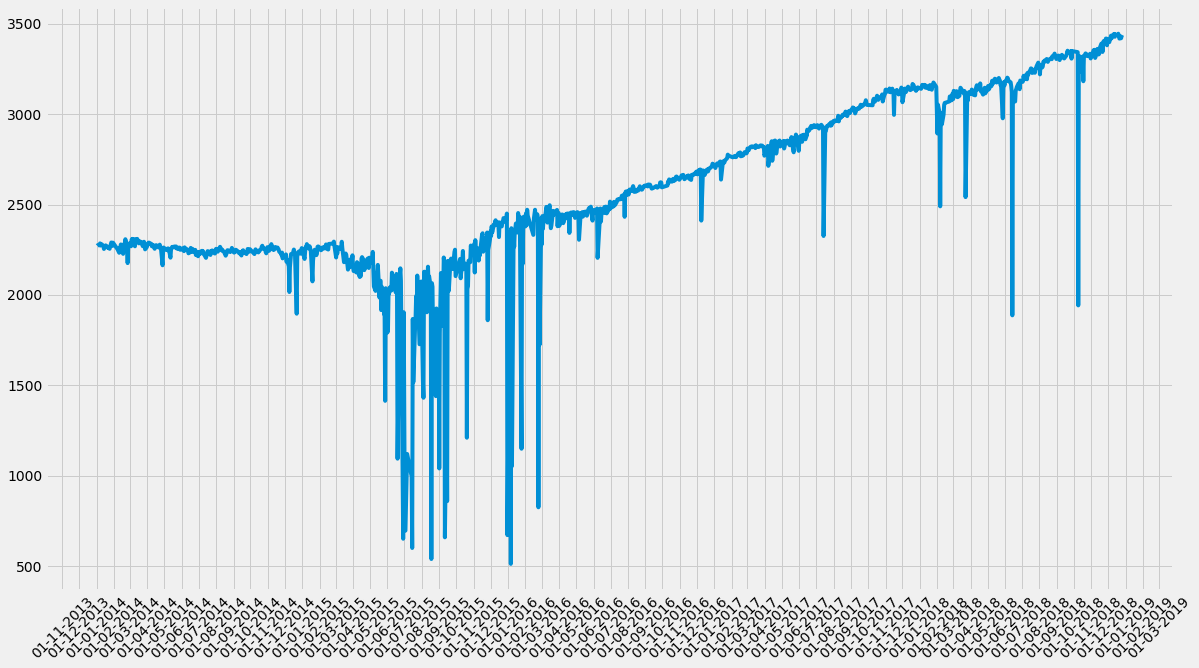

In [29]:
train_date_group = train.groupby('date').agg({'investment_id': 'count', 'target': ['mean', 'std']})
# train_date_group = train_date_group[(train_date_group.index > '2015-05-15') & (train_date_group.index < '2016-03-07')]

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)
plt.plot(train_date_group.index, train_date_group.investment_id['count'] , label="Number of unique investments")
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

Plot mean target value grouped by time_id against time

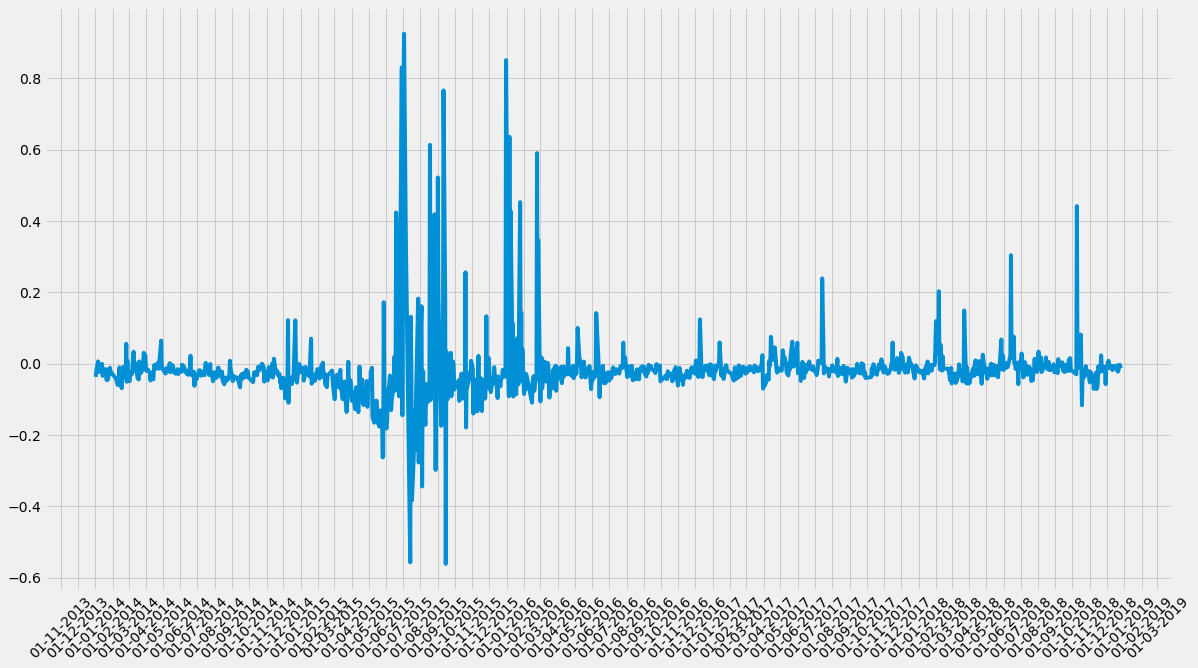

In [22]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)
plt.plot(train_date_group.index, train_date_group.target['mean'] , label="Number of unique investments")
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

Plot std of target grouped by time_id against time

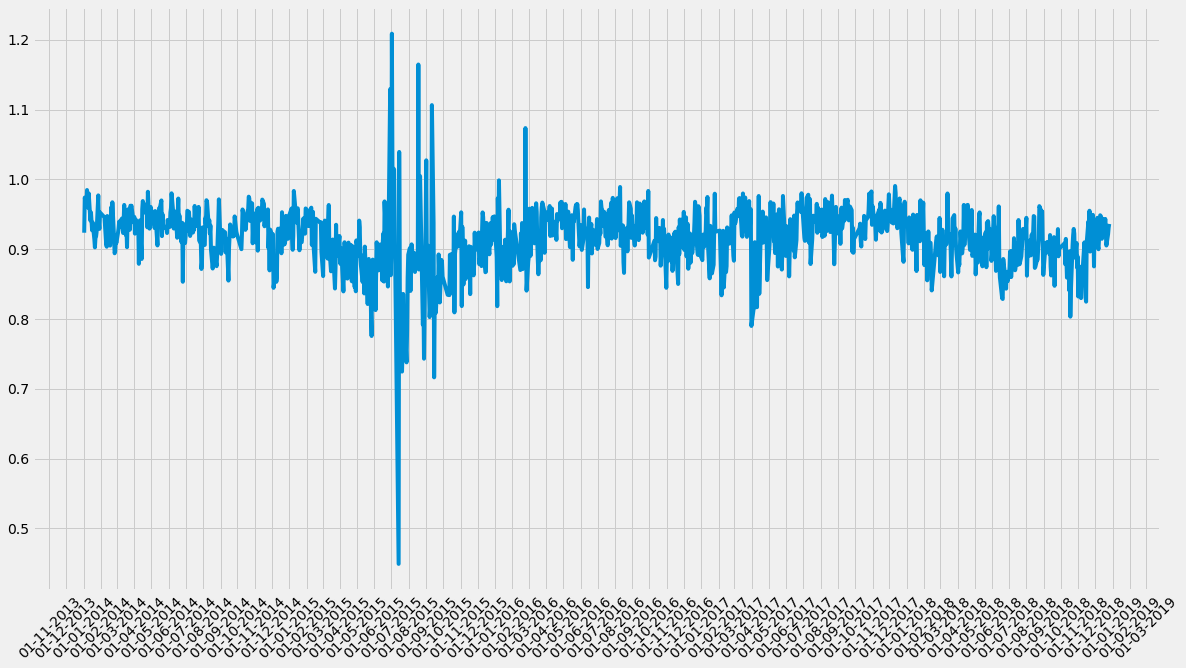

In [23]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)
plt.plot(train_date_group.index, train_date_group.target['std'] , label="Number of unique investments")
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

As we can see, segment of low number of unique investment ids and high volatility of target coinsides with period of Chineese stock market turbulence

# Define to what Chineese companies each stock belongs

In [110]:


investment_id = 0
period = 1

investment_id_history = train.loc[train.investment_id == investment_id, ['date','target']].set_index('date')
min_date = investment_id_history.index.min()# - timedelta(days=period)
max_date = investment_id_history.index.max()

ss_600000_history = yf.download("600000.SS", start=min_date, end=max_date)['Close']

[*********************100%***********************]  1 of 1 completed
